In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch import optim


import torchvision
from torchvision.transforms import v2
from torchvision import models
from torchvision.io import read_image
from torchvision import io, utils
from torchvision import tv_tensors

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import time
import json
import PIL
import tqdm as tqdm

# Custom imports
from utils import create_image_map, train_test_split, show_sample, color_jitter, gaussian_blur

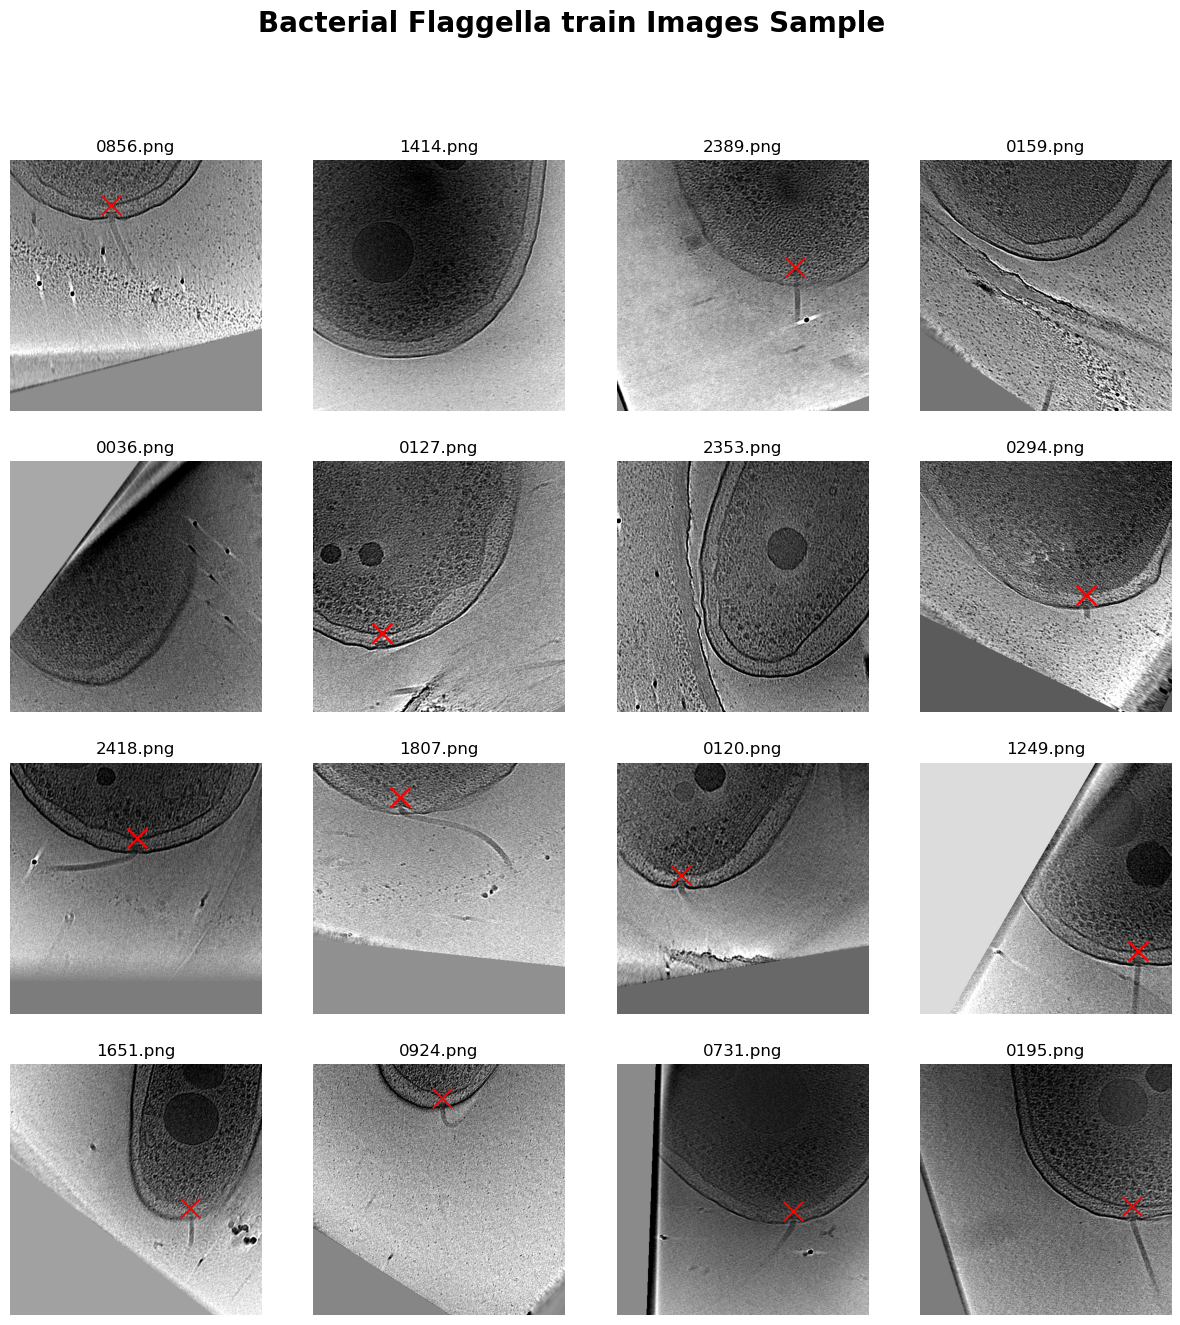

In [2]:
# Show sample images that we are working with to get a feel of what they are like and what data augmentation we might need
show_sample(4,4)

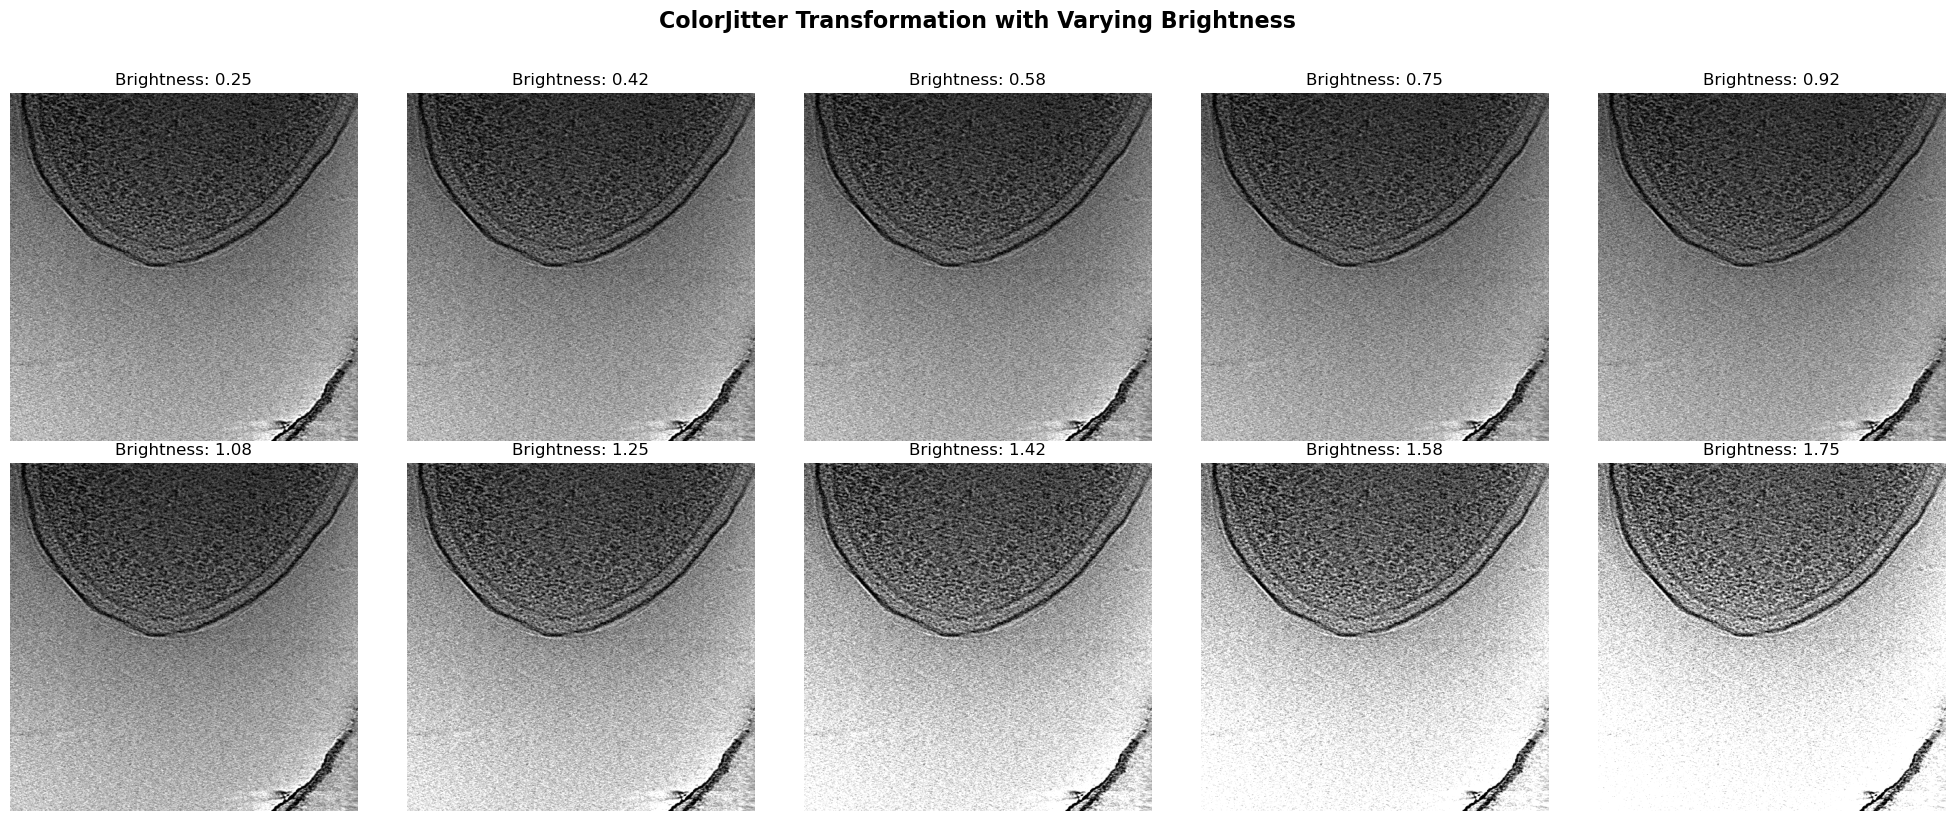

In [3]:
# check to see what colorjitter brightness would do to the images - some seem to be much much brighter and darker than others
color_jitter()

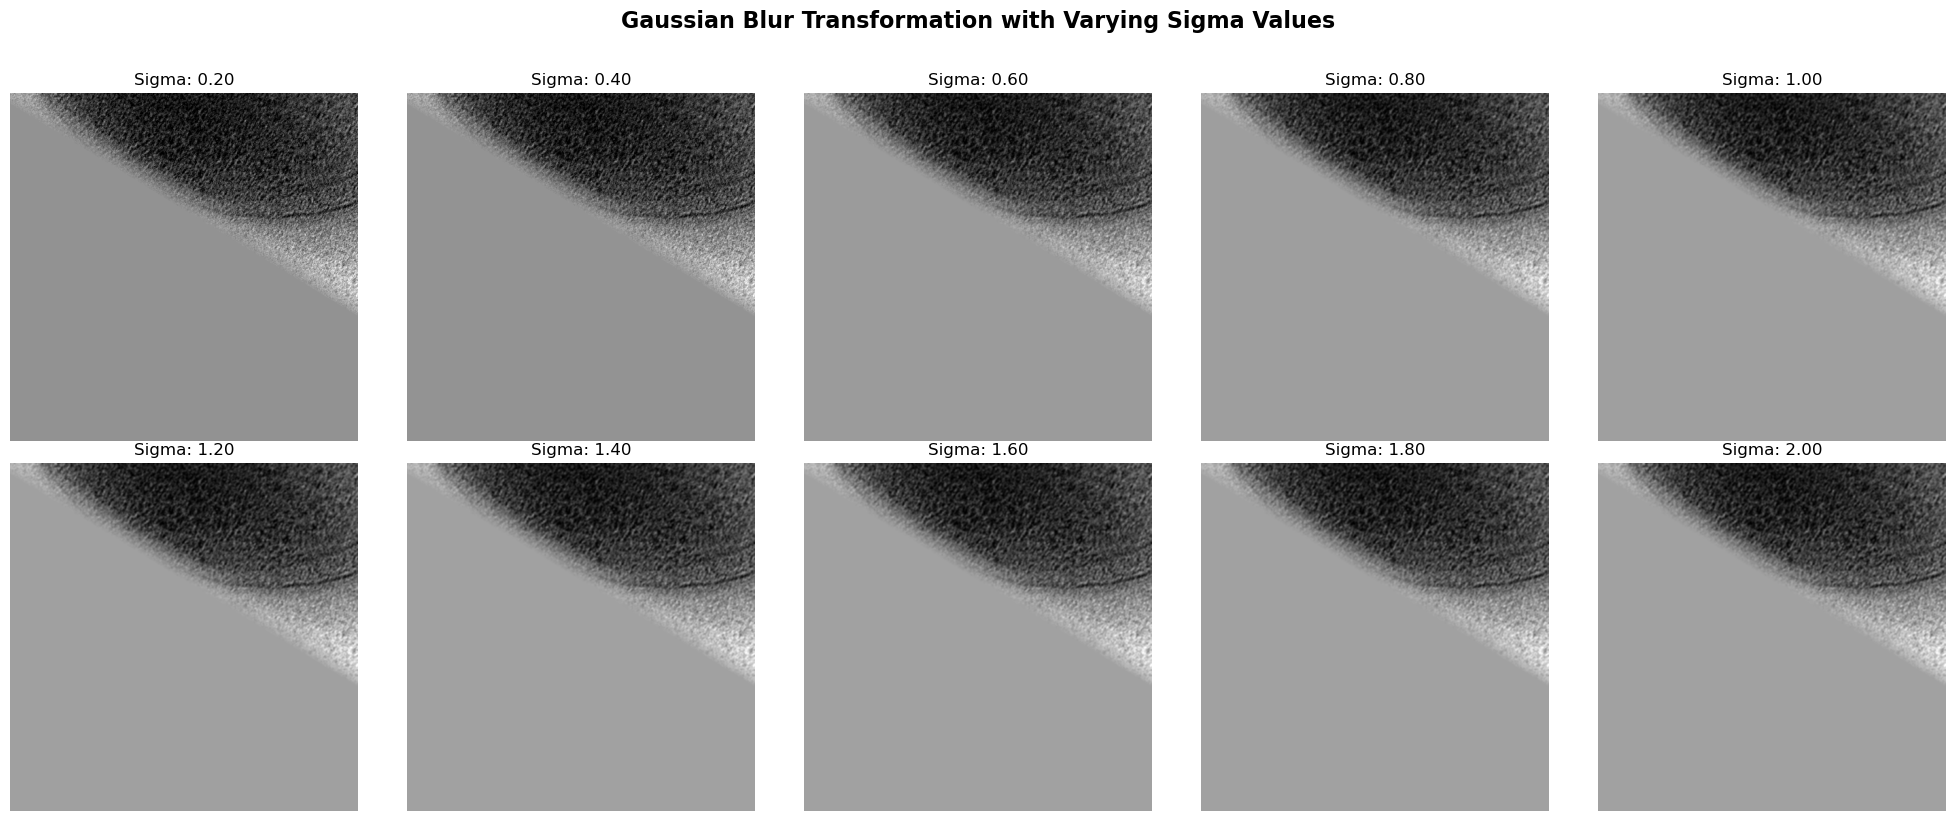

In [4]:
# Check to see what gaussian blur would do to the images
gaussian_blur()

In [20]:
# Create the dataset class
class TrainFlagellaMotors(Dataset):
    def __init__(self, images: list, image_map: dict, train=True, resize=None): 
        super(TrainFlagellaMotors, self).__init__()
        self.image_map = image_map
        self.images = images
        self.resize = resize
        self.train = train
        self.transform = v2.Compose([
                v2.RandomHorizontalFlip(p=0.5),
                v2.RandomVerticalFlip(p=0.5),
                v2.RandomRotation(degrees=[0,360]),
                v2.GaussianBlur(3, sigma=(0.1, 2.0)),
                v2.ColorJitter(brightness=[0.25,1.75])
            ])
                   

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = read_image(os.path.join('train',self.images[idx])) / 255.0
        x,y,motor_visible = (self.image_map[self.images[idx]]['x'], 
                 self.image_map[self.images[idx]]['y'], 
                 self.image_map[self.images[idx]]['motor_visible']) 
        if motor_visible:
            label = torch.tensor([motor_visible], dtype=torch.int64)
            box = torch.tensor([[x,y,x+1,y+1]], dtype=torch.float32)
        else:
            label = torch.tensor([motor_visible], dtype=torch.int64)
            box = torch.tensor([[0,0,1,1]], dtype=torch.float32)
        if self.train:
            boxes = tv_tensors.BoundingBoxes(box, format="XYXY", canvas_size=(image.shape[1], image.shape[2]))
            imgs, bboxes = self.transform(image, boxes)
            if not motor_visible:
                bboxes = torch.tensor([[0,0,1,1]], dtype=torch.float32)
        return imgs, bboxes, label

# Create validaton / submission dataset
class SubmissionFlagellaMotors(Dataset):
    def __init__(self): 
        super(SubmissionFlagellaMotors, self).__init__()
        self.folder = 'val'          
        self.images = os.listdir(self.folder)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        files = self.images[idx]
        file_path = os.path.join(self.folder, files)
        image = read_image(file_path)

        return image, files
        

In [24]:
train, test = train_test_split(0.1)
image_map = create_image_map()

In [25]:
train_dataset = TrainFlagellaMotors(train, image_map, train=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

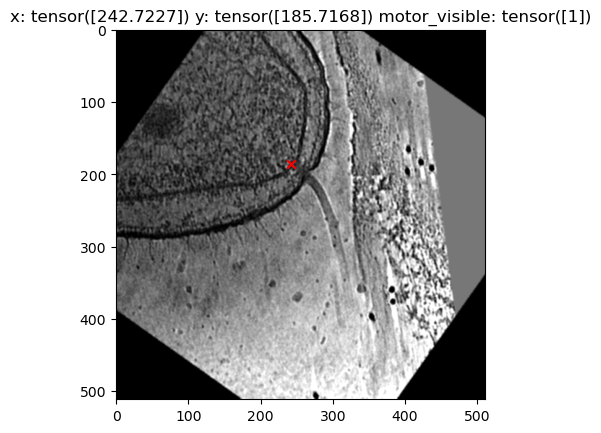

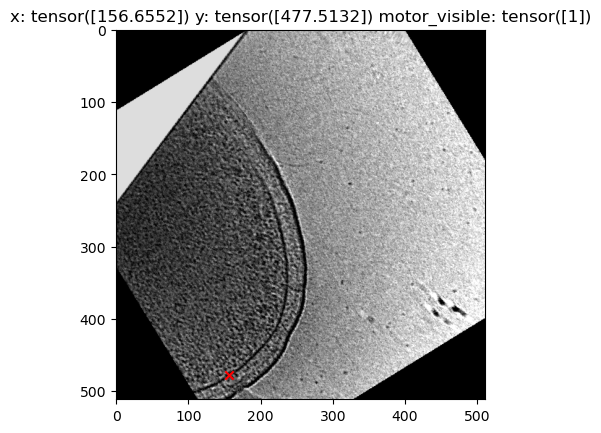

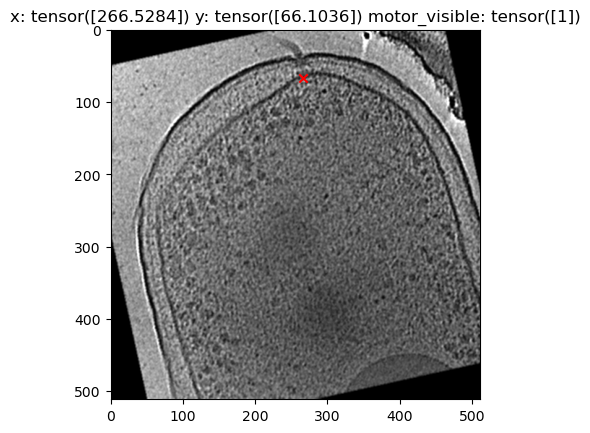

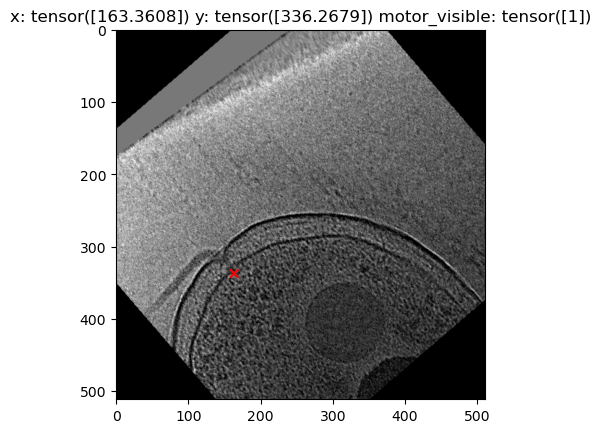

In [26]:
# Show a sample from the dataloader with the x and y coordinates and the motor visible boolean plotted
#HAVE TO DOUBLE CHECK TO MAKE SURE THAT ALL THE TRANSFORMS ARE WORKING AS EXPECTED AND APPLIED TO BOTH THE IMAGES AND THE BOXES
for img, box, label in train_loader:
    for i in range(4):
        plt.imshow(img[i].permute(1,2,0), cmap='gray')
        plt.scatter(box[i][:,0], box[i][:,1], marker='x', c='r')
        plt.title(f'x: {box[i][:,0]} y: {box[i][:,1]} motor_visible: {label[i]}')
        plt.show()
    break


In [7]:
!nvidia-smi

Fri Apr 12 14:40:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   61C    P8              13W /  80W |    209MiB /  6144MiB |     34%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
# This will give us a list of image names for the train and test set
# It also allows us to split the data randomly for cross validation metrics
train, test = train_test_split(test_ratio=0.1)

# Create a dictionary that maps image names to their respective labels
object_map = create_image_map()

In [ ]:
BATCH_SIZE = 8
EPOCHS = 10
LR = 0.001
validation_interval = 50

assert torch.cuda.is_available(), 'CUDA not available'

# Create dataset and dataloader
train_dataset = TrainFlagellaMotors(train, object_map)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TrainFlagellaMotors(test, object_map, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Submission dataset and dataloader
submission_dataset = SubmissionFlagellaMotors()
submission_dataloader = DataLoader(submission_dataset, batch_size=BATCH_SIZE, shuffle=False)

# set up the model, optimizer and loss function
rcnn_resnet_v2 = models.detection.fasterrcnn_resnet50_fpn_v2(num_classes=2, weights_backbone=True).cuda()
optimizer = optim.Adam(rcnn_resnet_v2.parameters(), lr=LR)

# Train the model
training_loss = []
testing_loss = []

for epoch in range(EPOCHS):
    epoch+=1
    rcnn_resnet_v2.train()
    loop = tqdm.tqdm(train_dataloader, total=len(train_dataloader))

    for batch, (image, box, label) in enumerate(train_dataloader):
        image , box, label = image.cuda(), box.cuda(), label.cuda()
        targets = []
        for i in range(BATCH_SIZE):
            d = {}
            d['boxes'] = box[i].cuda()
            d['labels'] = label[i].cuda()
            targets.append(d)
        optimizer.zero_grad()
        output = rcnn_resnet_v2(image, targets)
        loss = sum(loss for loss in output.values())
        loss.backward()
        optimizer.step()
        training_loss.append(loss.item())

        loop.set_description(f'Epoch: {epoch} Batch: {batch} Train Loss: {loss.item()} Test Loss: {testing_loss[-1] if len(testing_loss) > 0 else 0}')
        loop.update(1)